In [15]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import joblib
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import lightgbm as lgb
import xgboost as xgb
import optuna

# Set the path to find my dataprocessing functions
import sys
sys.path.append('./preprocessing')

# Load custom libraries
from vectorization import load_vectorizer, load_sparse_matrix


In [16]:
df = pd.read_csv('Data/NLP_cleaned.csv', index_col= 'ClaimNumber')

tfidf = load_vectorizer('tfidf_vectorizer.pkl')
X_tfidf = load_sparse_matrix('X_tfidf.npz')

In [17]:
# Define target and drop from features
y = df['UltimateIncurredClaimCost'].values
X = df.drop(columns=['UltimateIncurredClaimCost', 'DateTimeOfAccident', 'DateReported', 'ClaimDescription'], axis=1)

# Automatically select numeric and categorical columns by dtype
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Extract numeric data and scale
X_numeric = X[numeric_cols].values
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# One-hot encode categorical data, dropping first to avoid multicollinearity
ohe = OneHotEncoder(drop='first', sparse_output=True)
X_categorical = ohe.fit_transform(X[categorical_cols])

# Convert numeric and categorical to sparse matrices to combine with TF-IDF sparse matrix
X_numeric_sparse = sp.csr_matrix(X_numeric_scaled)
X_categorical_sparse = sp.csr_matrix(X_categorical)

# Stack numeric and categorical features horizontally
X_other = sp.hstack([X_numeric_sparse, X_categorical_sparse])

# Combine engineered features (TF-IDF) with other features
X_final = sp.hstack([X_other, X_tfidf])

In [ ]:
# Save scaler and one hot encoder for fitting test data

os.makedirs('models', exist_ok=True)

scaler.fit(X_numeric)
ohe.fit(X[categorical_cols])

joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(ohe, 'models/ohe.pkl')

['models/ohe.pkl']

In [33]:
# Fit OLS model

# Define adjusted R2 function
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Initialize the OLS model
lr_model = LinearRegression()

# Fit the model training data
lr_model.fit(X_final, y)

# Generate predictions on the training data
y_train_pred = lr_model.predict(X_final)

# Generate cross-validated predictions
y_val_pred = cross_val_predict(lr_model, X_final, y, cv=5, n_jobs=-1)

# Function to collect performance metrics
def get_metrics(y_true, y_pred, label):
    n = len(y_true)
    p = X_final.shape[1]
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'Adj_R2': adjusted_r2(r2, n, p),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect performance metrics
train_metrics = get_metrics(y, y_train_pred, 'OLS (Train)')
val_metrics = get_metrics(y, y_val_pred, 'OLS (Validation - CV)')

# Combine results
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)

# Save the model
joblib.dump(lr_model, 'models/ols_model.pkl')

                   Model          RMSE        R2    Adj_R2           MAE
0            OLS (Train)  46229.363079  0.257566  0.249210  15847.394490
1  OLS (Validation - CV)  46798.159758  0.239184  0.230621  16122.215659


['models/ols_model.pkl']

The next code block is fitting random forest without regularization.

In [ ]:
# Perform gridsearch for random forest hyperparameters without regularization

# Only a 20% randomized sample of the data was used here due to compute/time constraints
sample_frac = 0.2
df_sample = df.sample(frac=sample_frac, random_state=49)

# Convert sample index labels to integer row positions for sparse matrix slicing
row_positions = df.index.get_indexer(df_sample.index)

# Subset the combined sparse feature matrix using integer row positions
X_sample = X_final[row_positions, :]

# Subset target variable using .iloc with integer positions
y_sample = df.iloc[row_positions]['UltimateIncurredClaimCost']

# Define pipeline with Random Forest Regressor
pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=49))
])

# Parameter grid for GridSearch
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearch only on the sampled subset
grid_search.fit(X_sample, y_sample)

# Get the best pipeline
best_pipeline = grid_search.best_estimator_

# Extract the optimized hyperparameters
best_params = grid_search.best_params_

# Save the hyperparameters
joblib.dump(best_params, 'models/rf_best_params.pkl')


Fitting 5 folds for each of 24 candidates, totalling 120 fits


['models/rf_best_params.pkl']

In [5]:
rf_best_params = joblib.load('models/rf_best_params.pkl')
rf_best_params

{'rf__max_depth': 10,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 100}

In [ ]:
# Fit the random forest model using optimized hyperparameters

# Load the best parameters from grid search
joblib.load('models/rf_best_params.pkl')

# Adjusted R^2 function
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Initialize model
rf = RandomForestRegressor(
    n_estimators=best_params['rf__n_estimators'],
    max_depth=best_params['rf__max_depth'],
    min_samples_split=best_params['rf__min_samples_split'],
    min_samples_leaf=best_params['rf__min_samples_leaf'],
    random_state=49,
    n_jobs=-1
)

# Fit the model to the full training data
rf.fit(X_final, y)

# Predict on train data
y_train_pred = rf.predict(X_final)

# predict on cross validated model
y_val_pred = cross_val_predict(rf, X_final, y, cv=5, n_jobs=-1)

# Metrics helper
def get_metrics(y_true, y_pred, label):
    n = len(y_true)
    p = X_final.shape[1]
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'Adj_R2': adjusted_r2(r2, n, p),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'Random Forest (Train)')
val_metrics = get_metrics(y, y_val_pred, 'Random Forest (Validation - CV)')

# Combine metrics
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)


                             Model          RMSE        R2    Adj_R2  \
0            Random Forest (Train)  40153.286901  0.439902  0.433598   
1  Random Forest (Validation - CV)  46156.829378  0.259894  0.251564   

            MAE  
0  13497.862632  
1  14425.021733  


This next code block is fitting GBM without regularization.

In [31]:
# Search for optimal GBM hyperparameters

# Define pipeline with GBM
pipeline = Pipeline([
    ('gbm', GradientBoostingRegressor(random_state=49))
])

# Parameter grid for GridSearch
param_grid = {
    'gbm__n_estimators': [100],
    'gbm__learning_rate': [0.1, 0.05, 0.01],
    'gbm__max_depth': [3, 5, 7],
    'gbm__min_samples_split': [2, 5],
    'gbm__min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearch on the dataset
grid_search.fit(X_final, df['UltimateIncurredClaimCost'])

# Retrieve the best hyperparameters
best_pipeline = grid_search.best_estimator_

# Save the hyperparameters
best_params = grid_search.best_params_
joblib.dump(best_params, 'models/gbm_best_params.pkl')


Fitting 5 folds for each of 36 candidates, totalling 180 fits


['models/gbm_best_params.pkl']

In [7]:
gbm_best_params = joblib.load('models/gbm_best_params.pkl')
gbm_best_params

{'gbm__learning_rate': 0.05,
 'gbm__max_depth': 3,
 'gbm__min_samples_leaf': 2,
 'gbm__min_samples_split': 5,
 'gbm__n_estimators': 100}

In [32]:
# Fit the GBM model with optimized hyperparameters

# Load best parameters from grid search
best_params = joblib.load('models/gbm_best_params.pkl')

# Initialize GBM model using the best parameters from grid search
gbm = GradientBoostingRegressor(
    n_estimators=best_params['gbm__n_estimators'],
    learning_rate=best_params['gbm__learning_rate'],
    max_depth=best_params['gbm__max_depth'],
    min_samples_split=best_params.get('gbm__min_samples_split', 2),  # Defaulting to 2 if not found
    min_samples_leaf=best_params.get('gbm__min_samples_leaf', 1),  # Defaulting to 1 if not found
    random_state=49
)

# Fit the model to the full training data
gbm.fit(X_final, y)

# --- Predict on training data ---
y_train_pred = gbm.predict(X_final)

# --- Cross-validated predictions (validation performance) ---
y_val_pred = cross_val_predict(gbm, X_final, y, cv=5, n_jobs=-1)

# Metrics helper function
def get_metrics(y_true, y_pred, label):
    n = len(y_true)
    p = X_final.shape[1]
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'GBM (Train)')
val_metrics = get_metrics(y, y_val_pred, 'GBM (Validation - CV)')

# Combine results into a DataFrame for comparison
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)


                   Model          RMSE        R2           MAE
0            GBM (Train)  43494.936300  0.342797  14000.988140
1  GBM (Validation - CV)  45616.544656  0.277119  14330.583302


This next code section is fitting using lightgbm without regularization.

In [ ]:
# Search for optimal LightGBM hyperparameters

X_train = X_final
y_train = df['UltimateIncurredClaimCost']

# Define the pipeline
pipeline = Pipeline([
    ('lgbm', lgb.LGBMRegressor(random_state=49, verbose=-1))
])

# Adjusted parameter grid for LightGBM
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.05, 0.01],
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__num_leaves': [31, 50],  # LightGBM-specific, affects tree complexity
    'lgbm__min_child_samples': [5, 10]  # Equivalent to `min_samples_leaf` in GBM/XGBoost
}

# Set up GridSearchCV for LightGBM
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearch on data
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_pipeline = grid_search.best_estimator_

# Save the hyperparameters
best_params = grid_search.best_params_
joblib.dump(best_params, 'models/lgbm_best_params.pkl')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


['models/lgbm_best_params.pkl']

In [ ]:
# Fit LightGBM with optimized hyperparameters

# Load best parameters from grid search
best_params = joblib.load('models/lgbm_best_params.pkl')

# Initialize LightGBM model
lgbm = lgb.LGBMRegressor(
    n_estimators=best_params['lgbm__n_estimators'],
    learning_rate=best_params['lgbm__learning_rate'],
    max_depth=best_params['lgbm__max_depth'],
    num_leaves=best_params.get('lgbm__num_leaves', 31),  # Defaulting to 31 if not found
    min_child_samples=best_params.get('lgbm__min_child_samples', 10),  # Defaulting to 10 if not found
    random_state=42,
    verbose=-1
)

# Fit the model to the full training data
lgbm.fit(X_final, y)

# Predict on training data
y_train_pred = lgbm.predict(X_final)

# Cross-validated predictions
y_val_pred = cross_val_predict(lgbm, X_final, y, cv=5, n_jobs=-1)

# Metrics helper function
def get_metrics(y_true, y_pred, label):
    n = len(y_true)
    p = X_final.shape[1]
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'LightGBM (Train)')
val_metrics = get_metrics(y, y_val_pred, 'LightGBM (Validation - CV)')

# Combine results
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)


C:\Users\brien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                        Model          RMSE        R2           MAE
0            LightGBM (Train)  43983.732816  0.327943  13954.890971
1  LightGBM (Validation - CV)  45441.055999  0.282670  14254.671916


This next code block is fitting xgboost without regularization.

In [ ]:
# Search for optimal XGBoost hyperparameters

X_train = X_final
y_train = df['UltimateIncurredClaimCost']

# Define pipeline with XGBoost Regressor
pipeline = Pipeline([
    ('xgb', 
    xgb.XGBRegressor(objective='reg:squarederror', 
    random_state=49, 
    verbosity=1, 
    tree_method='hist'))
])

# Adjusted parameter grid for XGBoost
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.1, 0.05, 0.01],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 1.0],  # Fraction of training samples used per boosting round
    'xgb__colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'xgb__min_child_weight': [1, 5]  # Equivalent to min_samples_leaf in LightGBM
}

# Set up GridSearchCV for XGBoost
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearch on entire dataset
grid_search.fit(X_train, y_train)

# Retrieve the best pipeline (with optimized hyperparameters)
best_pipeline = grid_search.best_estimator_

# Save the best parameters dictionary to a file
best_params = grid_search.best_params_
joblib.dump(best_params, 'models/xgb_best_params.pkl')


Fitting 5 folds for each of 144 candidates, totalling 720 fits


['models/xgb_best_params.pkl']

In [ ]:
# Fit XGBoost model with optimized hyperparameters

# Load best parameters from grid search
best_params = joblib.load('models/xgb_best_params.pkl')

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['xgb__n_estimators'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    subsample=best_params.get('xgb__subsample', 1.0),  # Defaulting to 1.0 if not found
    colsample_bytree=best_params.get('xgb__colsample_bytree', 1.0),  # Defaulting to 1.0 if not found
    min_child_weight=best_params.get('xgb__min_child_weight', 1),  # Defaulting to 1 if not found
    objective='reg:squarederror',
    random_state=49,
    verbosity=1,
    tree_method='hist'  # Optimized for speed on large datasets
)

# Fit the model to the full training data
xgb_model.fit(X_final, y)

# Predict on training data
y_train_pred = xgb_model.predict(X_final)

# Cross-validated predictions
y_val_pred = cross_val_predict(xgb_model, X_final, y, cv=5, n_jobs=-1)

# Metrics helper function
def get_metrics(y_true, y_pred, label):
    n = len(y_true)
    p = X_final.shape[1]
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'XGBoost (Train)')
val_metrics = get_metrics(y, y_val_pred, 'XGBoost (Validation - CV)')

# Combine results into a DataFrame for comparison
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)

# Save the trained model
joblib.dump(xgb_model, 'models/xgb_trained_model.pkl')

# Load it later for inference
xgb_model = joblib.load('models/xgb_trained_model.pkl')

                       Model          RMSE        R2           MAE
0            XGBoost (Train)  44240.764768  0.320065  14072.723872
1  XGBoost (Validation - CV)  45520.518022  0.280159  14303.856369


This next code block implements l1 and l2 regularization with xgboost.

In [ ]:
# Search for optimal hyperparameters with regularization

# Feature matrix and target
X_train = X_final
y_train = df['UltimateIncurredClaimCost']

# Define pipeline with XGBoost Regressor
pipeline = Pipeline([
    ('xgb', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=49,
        verbosity=1,
        tree_method='hist'
    ))
])

# Parameter grid including regularization terms
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.1, 0.05, 0.01],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__min_child_weight': [1, 5],
    'xgb__reg_alpha': [0, 0.1, 1],      # L1 regularization (sparsity)
    'xgb__reg_lambda': [1, 5, 10]       # L2 regularization (shrinkage)
}

# Set up GridSearchCV for XGBoost
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearch on training data
grid_search.fit(X_train, y_train)

# Retrieve best pipeline and best parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

# Save the best parameters with a new filename
joblib.dump(best_params, 'models/xgbR_best_params.pkl')


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


['models/xgbR_best_params.pkl']

In [8]:
xgbR_best_params = joblib.load('models/xgbR_best_params.pkl')
xgbR_best_params

{'xgb__colsample_bytree': 0.8,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 200,
 'xgb__reg_alpha': 1,
 'xgb__reg_lambda': 10,
 'xgb__subsample': 1.0}

In [ ]:
# Fit the XGBoost model with optimized hyperparameters

# Load the best parameters from the grid search with regularization
best_params = joblib.load('models/xgbR_best_params.pkl')

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['xgb__n_estimators'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    subsample=best_params.get('xgb__subsample', 1.0),
    colsample_bytree=best_params.get('xgb__colsample_bytree', 1.0),
    min_child_weight=best_params.get('xgb__min_child_weight', 1),
    reg_alpha=best_params.get('xgb__reg_alpha', 0),
    reg_lambda=best_params.get('xgb__reg_lambda', 1),
    objective='reg:squarederror',
    random_state=49,
    verbosity=1,
    tree_method='hist'
)

# Fit the model to the full training data
xgb_model.fit(X_final, y)

# Predict on training data
y_train_pred = xgb_model.predict(X_final)

# Cross-validated predictions
y_val_pred = cross_val_predict(xgb_model, X_final, y, cv=5, n_jobs=-1)

# Metrics helper function
def get_metrics(y_true, y_pred, label):
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'XGBoost (Train)')
val_metrics = get_metrics(y, y_val_pred, 'XGBoost (Validation - CV)')

# Combine results
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)

# Save the trained model
joblib.dump(xgb_model, 'models/xgbR_trained_model.pkl')


                       Model          RMSE       R2           MAE
0            XGBoost (Train)  44131.814040  0.32341  13948.964519
1  XGBoost (Validation - CV)  45376.394168  0.28471  14197.748994


['models/xgbR_trained_model.pkl']

This next code block uses bayesian hyperparemeter search with regularization on lightgbm.

In [ ]:
# Bayesian hyperparameter search with regularization

X_train = X_final
y_train = df['UltimateIncurredClaimCost']

def objective(trial):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 31, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        # Regularization terms:
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.0, 0.1),
        'random_state': 49,
        'verbose': -1
    }

    # Initialize the model
    model = lgb.LGBMRegressor(**param)
    
    # Use cross-validation to evaluate performance.
    scores = cross_val_score(model, X_train, y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error', 
                             n_jobs=-1)
                             
    # Return the RMS
    rmse = np.sqrt(-scores.mean())
    return rmse

# Create a study object specifying that we want to minimize the RMSE
study = optuna.create_study(direction='minimize')

# Optimize the study by evaluating 100 trials
study.optimize(objective, n_trials=100)

# Extract the best hyperparameters
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Save the hyperparameters
joblib.dump(best_params, 'models/lgbm_best_params_optuna.pkl')


[I 2025-06-06 02:46:48,713] A new study created in memory with name: no-name-9333b0f9-ed96-4a4f-ac7e-6c4d0c9e20d3
C:\Users\brien\AppData\Local\Temp\ipykernel_7932\2103451473.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\brien\AppData\Local\Temp\ipykernel_7932\2103451473.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
C:\Users\brien\AppData\Local\Temp\ipykernel_7932\2103451473.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

Best hyperparameters: {'n_estimators': 200, 'learning_rate': 0.034954958253914745, 'max_depth': 3, 'num_leaves': 36, 'min_child_samples': 10, 'reg_alpha': 0.5178410567578727, 'reg_lambda': 9.493530719957567e-05, 'min_split_gain': 0.020784538852168948}


['models/lgbm_best_params_optuna.pkl']

In [9]:
lgbm_best_params_optuna = joblib.load('models/lgbm_best_params_optuna.pkl')
lgbm_best_params_optuna

{'n_estimators': 200,
 'learning_rate': 0.034954958253914745,
 'max_depth': 3,
 'num_leaves': 36,
 'min_child_samples': 10,
 'reg_alpha': 0.5178410567578727,
 'reg_lambda': 9.493530719957567e-05,
 'min_split_gain': 0.020784538852168948}

In [ ]:
# Fit LightGBM with optimized hyperparameters

# Load optimized hyperparameters
best_params = joblib.load('models/lgbm_best_params_optuna.pkl')

# Initialize LightGBM
lgbm = lgb.LGBMRegressor(
    n_estimators=best_params.get('n_estimators', 100),
    learning_rate=best_params.get('learning_rate', 0.1),
    max_depth=best_params.get('max_depth', 3),
    num_leaves=best_params.get('num_leaves', 31),
    min_child_samples=best_params.get('min_child_samples', 10),
    reg_alpha=best_params.get('reg_alpha', 0.0),       
    reg_lambda=best_params.get('reg_lambda', 0.0),    
    min_split_gain=best_params.get('min_split_gain', 0.0), 
    random_state=49,
    verbose=-1
)

# Fit the model to the full training data
lgbm.fit(X_final, y)

# Predict on training data
y_train_pred = lgbm.predict(X_final)

# Cross-validated predictions
y_val_pred = cross_val_predict(lgbm, X_final, y, cv=5, n_jobs=-1)

# Metrics helper function
def get_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2,
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Collect both sets of metrics
train_metrics = get_metrics(y, y_train_pred, 'LightGBM (Train)')
val_metrics = get_metrics(y, y_val_pred, 'LightGBM (Validation - CV)')

# Combine results
results_df = pd.DataFrame([train_metrics, val_metrics])
print(results_df)

# Save the trained model
joblib.dump(lgbm, 'models/lgbm_model.pkl')

C:\Users\brien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                        Model          RMSE        R2           MAE
0            LightGBM (Train)  44272.579176  0.319087  13992.688167
1  LightGBM (Validation - CV)  45414.984496  0.283493  14214.781986


['models/lgbm_model.pkl']

<Figure size 1000x800 with 0 Axes>

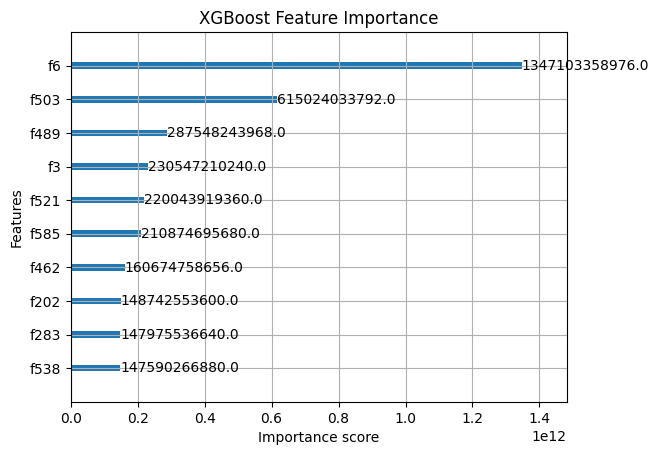

In [10]:
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the trained XGBoost model from file
xgb_model_loaded = joblib.load('models/xgbR_trained_model.pkl')

# Option to choose the importance type (e.g., 'gain', 'weight', or 'cover')
importance_type = 'gain'

# Create a figure for the plot
plt.figure(figsize=(10, 8))

# Plot the feature importance
xgb.plot_importance(xgb_model_loaded, importance_type=importance_type, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

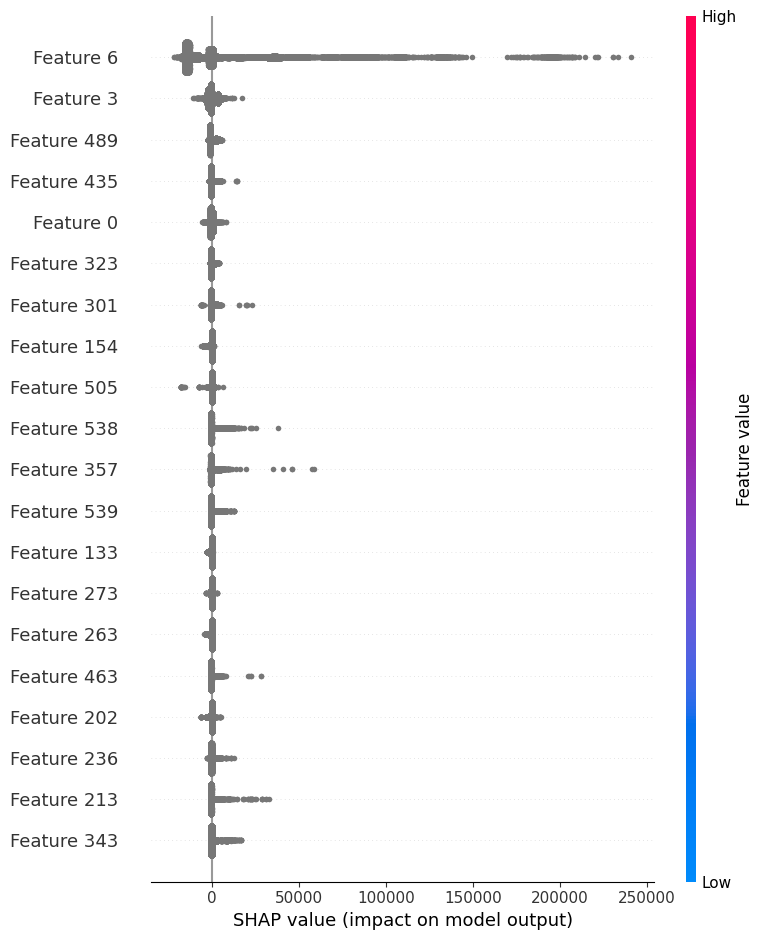

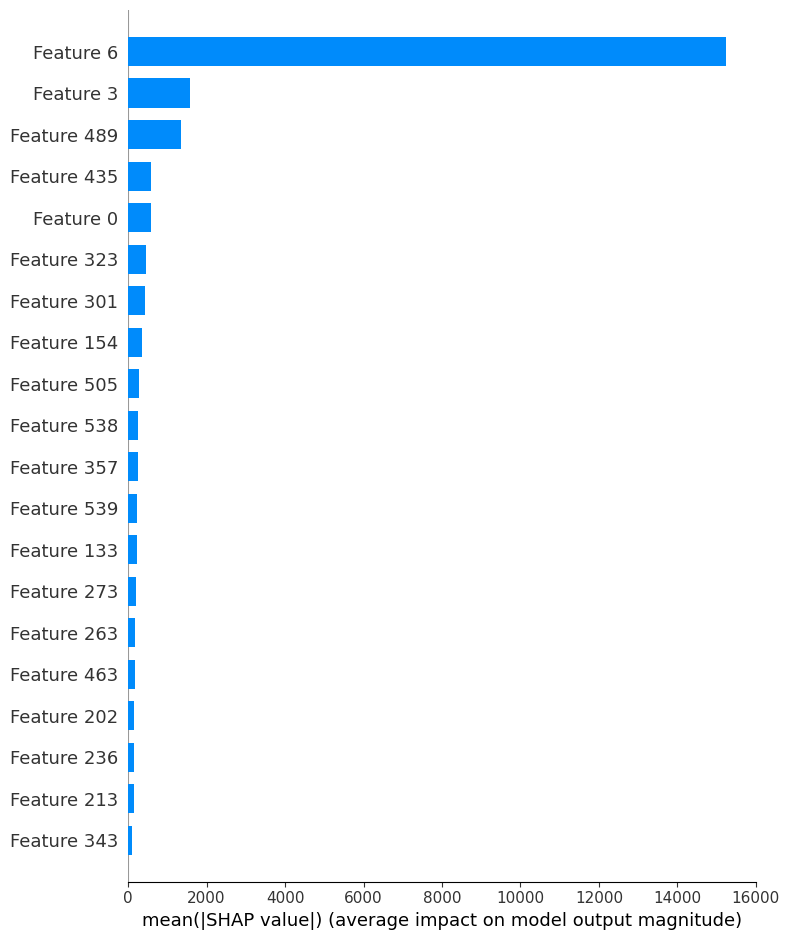

In [19]:
import shap

# Load your pre-trained XGBoost model
xgb_model = joblib.load('models/xgbR_trained_model.pkl')

# Initialize a SHAP TreeExplainer for your XGBoost model.
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for your dataset.
# For XGBoost models, TreeExplainer works very well.
shap_values = explainer.shap_values(X_final)

# Generate a summary plot that shows the impact of each feature.
# The standard summary plot is a beeswarm plot.
shap.summary_plot(shap_values, X_final)

# Optionally, generate a bar plot summary to display average feature importance.
shap.summary_plot(shap_values, X_final, plot_type="bar")

# Optionally, create a dependence plot for a single feature (replace 'feature_name' with an actual column name)
# shap.dependence_plot("feature_name", shap_values, X_final)